# Hands-on session on Digital Volume Correlation with <tt>SPAM
    
@ Olga Stamati: olga.stamati@esfr.fr

   

## Outline

- What is <tt>SPAM</tt>?
- Let's load an X-ray image
- Local DVC
- Discrete DVC    
- <font color="red">**Global DVC**</font>
- Multimodal registration

##  Clarification

Unfortunately the global DVC in <tt>SPAM</tt> is currently **under development**.<br>
This means that it is not included **yet** in the master branch.<br>
This means that unless you've installed a developers version (with `git clone`), you can't run the source code of global DVC... (sorry!)

##  Reminder of correlation functional

We're trying to minimise the functional:<br>

$ \hspace{2.5cm} \mathcal{T}(\boldsymbol{\Phi}) = \sum_{x \in \Omega} \left(f(x) - g(\boldsymbol{\Phi}\cdot x)\right)^2 \hspace{0.6cm}$

Until now me measured:
- a **single** deformation function (`spam-reg`), where $\Omega$ includes all the pixels of the **image**
- a **field** of deformation functions defined in a regular grid (`spam-ldic`), where we had **many independent** $\Omega$, each including all the pixels inside a **correlation window**


##  Correlation functional in global DVC

We're trying to minimise the functional:<br>

$ \hspace{2.5cm} \boldsymbol{\Phi}_\text{c} = \sum_{x \in \Omega} \left[f(x) - g(x + u(x))\right]^2 \hspace{0.6cm}$<br>

---
In a matrix-vector format:<br>
$  \hspace{4cm} \boldsymbol{M}_\text{c} \delta{\boldsymbol d} = \boldsymbol{b}$

where:<br>
- ${\boldsymbol u}(x) = \boldsymbol{N}(x){\boldsymbol d}$ is the standard FE displacement field
- $\delta{\boldsymbol d}$ is the increment of the unknown nodal displacements
- $\boldsymbol{M}_c$ is the Hessian, built from the shape funciton and image gradient
- $\boldsymbol{b}$ contains the residual supported by the shape functions

In [11]:
import spam.datasets
import spam.deformation
import matplotlib.pyplot as plt; plt.rcParams['xtick.labelsize'] = 15; plt.rcParams['ytick.labelsize'] = 15

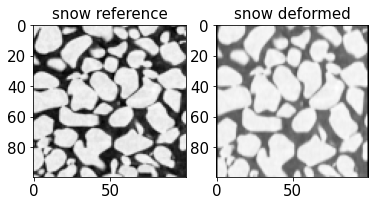

In [37]:
snowRef = spam.datasets.loadSnow()
Phi = spam.deformation.computePhi({"z": [1.2, 1, 1]})
snowDef = spam.DIC.applyPhi(snowRef, Phi=Phi)

plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1), plt.title("snow reference", fontsize=15)
plt.imshow(snowRef[:, snowRef.shape[1]//2], cmap="Greys_r")
plt.subplot(1, 2, 2), plt.title("snow deformed", fontsize=15)
plt.imshow(snowDef[:, snowDef.shape[1]//2], cmap="Greys_r")
plt.show()

### Create an unstructured tetrahedral mesh

In [38]:
meshCharacteristicLength = 10 # pixels
margin                   = 10 # pixels

points, connectivity = spam.mesh.createCuboid([snowRef.shape[0] - 4 * margin,
                                               snowRef.shape[1] - 4 * margin,
                                               snowRef.shape[2] - 4 * margin
                                              ],
                                              meshCharacteristicLength,
                                              origin=[2 * margin, 2 * margin, 2 * margin],
                                              vtkFile=f"snow-mesh-l{meshCharacteristicLength}"
                                             )



### Load mesh in ParaView...

### Initial Guess

Yes, you guessed correctly!<br>
Once again, it will be nice if we pass an initial guess!

---
This time, we need to pass the initial displacement to the **nodes** of the FE mesh.<br>
There's a convenient function for this.

In [34]:
PhiGuess = spam.deformation.computePhi({'z': [1.1, 1.0, 1.0]})
initialDisplacements = spam.DIC.applyRegistrationToPoints(PhiGuess,
                                                          (numpy.array(snowRef.shape) - 1) / 2.0,
                                                          points,
                                                          applyF='no'
                                                          )[:, 0:3, -1]

In [39]:
returns = spam.DIC.globalCorrelation(snowRef, snowDef,
                                     points, connectivity,
                                     #regularisation={"ksi_bulk": meshCharacteristicLength,
                                     #                "young": 1,
                                     #                "poisson": 0.33,
                                     #                "bc_dirichlet": [[0, 10, 0],  # [direction position dof]
                                     #                                 [0, 90, 0],
                                     #                                ]
                                     #               },
                                      convergenceCriterion=0.02, maxIterations=50,                
                                      #initialDisplacements=initialDisplacements,
                                      medianFilterEachIteration=True,
                                      verbose=True, debugFiles=True, prefix="regOff-noInitialGuess"
                                     )


spam.DIC.globalCorrelation(): convergenceCriterion = 0.02
spam.DIC.globalCorrelation(): maxIterations = 50
spam.DIC.globalCorrelation(): converting im1 to 32-bit float
	spam.DIC.globalCorrelation(): mesh box:
		min coords: [20 20 20]
		max coords: [80 80 80]
	spam.DIC.globalCorrelation():
		Points:  (387, 3)
		Cells: (1328, 4)
		Mesh  Padding: (slice(20, 80, None), slice(20, 80, None), slice(20, 80, None))
	spam.DIC.globalCorrelation(): Allocating 3D data (deformed image)
	spam.DIC.globalCorrelation(): Calculating gradient of IM TWO...
	spam.DIC.globalCorrelation(): Computing global matrix
	i=001, displacements min=-4.922 -2.302 -3.510, median= 0.019  0.021 -0.013, max= 4.406  3.006  3.316, dx=45.56
	i=002, displacements min=-8.700 -2.765 -6.759, median= 0.033  0.016 -0.009, max= 3.962  4.406  3.956, dx=41.01
	i=003, displacements min=-7.491 -2.622 -9.619, median= 0.005  0.009 -0.003, max= 6.142  6.434  4.561, dx=42.32
	i=004, displacements min=-7.190 -3.015 -5.671, median= 0.046  0.00

##  Mechanical regularisation in global DVC

We're trying to minimise the functional:<br>

$ \hspace{2.5cm} \boldsymbol{\Phi}_\text{c} = \sum_{x \in \Omega} \left[f(x) - g(x + u(x))\right]^2 \hspace{0.6cm}$<br>

Total functional which includes correlation and mechanical regularisation (Neumann and Dirichlet DOFs)

$ \hspace{2.5cm} \boldsymbol{\Phi}_\text{t} = \boldsymbol{\Phi}_\text{c} + \boldsymbol{\Phi}_\text{m} + \boldsymbol{\Phi}_\text{S}$ <br>

---
In a matrix-vector format:<br>
$  \hspace{4cm} \left(\boldsymbol{M}_\text{c} + \boldsymbol{M}_\text{reg}\right) \delta{\boldsymbol d} = \boldsymbol{b} - \boldsymbol{M}_\text{reg} \delta{\boldsymbol d}$

where:<br>
- $ \boldsymbol{M}_\text{reg} = \underbrace{\boldsymbol{M}_\text{m}}_\text{Neumann} + \underbrace{\sum_{\mathcal{S}_i}\boldsymbol{M}_{\mathcal{S}_i}}_\text{Dirichlet} $

In [41]:
returns = spam.DIC.globalCorrelation(snowRef, snowDef,
                                     points, connectivity,
                                     regularisation={"ksi_bulk": meshCharacteristicLength,
                                                     "young": 1,
                                                     "poisson": 0.33,
                                                     "bc_dirichlet": [[0, 10, 0],  # [direction position dof]
                                                                      [0, 90, 0],
                                                                     ]
                                                    },
                                      convergenceCriterion=0.02, maxIterations=50,                
                                      #initialDisplacements=initialDisplacements,
                                      medianFilterEachIteration=True,
                                      verbose=True, debugFiles=True, prefix="regOn-noInitialGuess"
                                     )


spam.DIC.globalCorrelation(): convergenceCriterion = 0.02
spam.DIC.globalCorrelation(): maxIterations = 50
spam.DIC.globalCorrelation(): converting im1 to 32-bit float
	spam.DIC.globalCorrelation(): mesh box:
		min coords: [20 20 20]
		max coords: [80 80 80]
	spam.DIC.globalCorrelation():
		Points:  (387, 3)
		Cells: (1328, 4)
		Mesh  Padding: (slice(20, 80, None), slice(20, 80, None), slice(20, 80, None))
	spam.DIC.globalCorrelation(): Allocating 3D data (deformed image)
	spam.DIC.globalCorrelation(): Calculating gradient of IM TWO...
	spam.DIC.globalCorrelation(): Computing global matrix
DEBUG: Regularisation
{'ksi_bulk': 10, 'young': 1, 'poisson': 0.33, 'bc_dirichlet': [[0, 10, 0], [0, 90, 0]]}
DEBUG: compute surfaces based on min/max mesh coordinates
DEBUG: k = [0.05, 0, 0]
DEBUG: Ec = 377117529257.7839, Em = 109565.7700178542
DEBUG: omega_c = 1.0, omega_m = 0.0625, 1. / k_mag = 20.0
	i=001, displacements min=-1.972 -2.291 -2.535, median= 0.050  0.003 -0.008, max= 2.096  1.563  1.9